<a href="https://colab.research.google.com/github/ldsbalu/Balu-Portfolio/blob/main/LLM_Text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Preparing DataSet




In [1]:
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 150.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.2
    Uninstalling transformers-4.56.2:
      Successfully uninstalled transformers-4.56.2


In [2]:
import pandas as pd
import torch
from datasets import Dataset as HFDataset
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    pipeline
)

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0+cu126


In [3]:
# print("Loading dataset...")
# dataset = load_dataset("sms_spam", "plain_text")
# print("Dataset loaded successfully!")

In [21]:

print("Loading dataset...")
# 1. Load your data from the CSV file into a pandas DataFrame
df = pd.read_csv("iphone.csv")

# 2. Remove any rows with missing prompts or completions
df.dropna(subset=['prompt', 'completion'], inplace=True)

# 3. Convert the cleaned DataFrame into a Dataset object
print("Converting to Hugging Face Dataset...")
dataset_hf = HFDataset.from_pandas(df)


print("Dataset loaded successfully!")

Loading dataset...
Dataset loaded successfully!


In [22]:
train_test_split = dataset_hf.train_test_split(test_size=0.2, seed=42)
train_dataset_hf = train_test_split['train']
val_dataset_hf = train_test_split['test']



In [23]:
print(f"Training set size: {len(train_dataset_hf)}")
print(f"Validation set size: {len(val_dataset_hf)}")
print("\nSample from training data:")
print(train_dataset_hf[0])

Training set size: 171
Validation set size: 43

Sample from training data:
{'prompt': "What is 'Reachability'?", 'completion': 'Reachability is a feature that makes it easier to use larger iPhones with one hand. Swipe down on the bottom edge of the screen to bring the top half of the display down into easy reach of your thumb.'}


creating Data loaders


In [52]:
class PromptCompletionDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_length=256):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
      example = self.dataset[index]
      prompt = str(example["prompt"])
      completion = str(example["completion"])
      combined_text = prompt + self.tokenizer.eos_token + completion
      encodings = self.tokenizer(
          combined_text,
          truncation=True,
          padding="max_length",
          max_length=self.max_length,
          return_tensors="pt"
      )
      input_ids = encodings["input_ids"].squeeze(0)
      attention_mask = encodings["attention_mask"].squeeze(0)
      labels = input_ids.clone()
      return {
          "input_ids": input_ids,
          "attention_mask": attention_mask,
          "labels": labels
      }



In [62]:
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

train_dataset_torch = PromptCompletionDataset(
    hf_dataset=train_dataset_hf,
    tokenizer=tokenizer,
    max_length=256
)

validation_dataset_torch = PromptCompletionDataset(
    hf_dataset=val_dataset_hf,
    tokenizer=tokenizer,
    max_length=256
)

print(f"Max length for tokenization is: {train_dataset_torch.max_length}")
print(f"Number of training samples: {len(train_dataset_torch)}")
print(f"Number of validation samples: {len(validation_dataset_torch)}")



Max length for tokenization is: 256
Number of training samples: 171
Number of validation samples: 43


In [63]:
print("Example item from training set:")
print(train_dataset_torch[0])


Example item from training set:
{'input_ids': tensor([ 2061,   318,   705,  3041,   620,  1799, 30960, 50256,  3041,   620,
         1799,   318,   257,  3895,   326,  1838,   340,  4577,   284,   779,
         4025, 33845,   351,   530,  1021,    13,  2451,  3757,   866,   319,
          262,  4220,  5743,   286,   262,  3159,   284,  2222,   262,  1353,
         2063,   286,   262,  3359,   866,   656,  2562,  3151,   286,   534,
        15683,    13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 502

In [65]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return {
        "input_ids": torch.stack([item["input_ids"] for item in batch]),
        "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
        "labels": torch.stack([item["labels"] for item in batch])
    }
# Training DataLoader (shuffle for training)
train_loader = DataLoader(
    train_dataset_torch,
    batch_size=8,
    shuffle=True
)

# Validation DataLoader (no shuffle)
val_loader = DataLoader(
    validation_dataset_torch,
    batch_size=8,
    shuffle=False
)



In [66]:
print("Inspecting a batch from the DataLoader:")
for batch in train_loader:
    input_batch = batch["input_ids"]
    target_batch = batch["labels"]

    print("Input batch dimensions:", input_batch.shape)
    print("Label batch dimensions:", target_batch.shape)
    break

Inspecting a batch from the DataLoader:
Input batch dimensions: torch.Size([8, 256])
Label batch dimensions: torch.Size([8, 256])


In [56]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")

22 training batches
6 validation batches


initilizing the model with preptrained models

In [67]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)


In [73]:
def tokenize_function(examples):
    # Merge prompt and completion with EOS between, capped at max_length
    text = [p + tokenizer.eos_token + c for p, c in zip(examples["prompt"], examples["completion"])]
    result = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=128
    )
    result["labels"] = result["input_ids"].copy()
    return result


In [74]:
tokenized_train = train_dataset_hf.map(tokenize_function, batched=True)
tokenized_val = val_dataset_hf.map(tokenize_function, batched=True)

Map:   0%|          | 0/171 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

In [75]:
training_args = TrainingArguments(
    output_dir="./iphone_results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_steps=10,

)

In [76]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)

# 5. Train the model
print("Starting the fine-tuning and evaluation process...")
trainer.train()

# 6. Explicitly evaluate the final best model
final_metrics = trainer.evaluate()
print("\nFinal Evaluation Metrics:")
print(final_metrics)

Starting the fine-tuning and evaluation process...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,2.471100
20,1.301600
30,1.226700
40,1.127100
50,1.140000
60,0.972400
70,0.974100
80,1.032500
90,0.982700
100,0.937000



Final Evaluation Metrics:
{'eval_loss': 1.0642690658569336, 'eval_runtime': 0.5464, 'eval_samples_per_second': 78.699, 'eval_steps_per_second': 20.132, 'epoch': 3.0}


In [78]:

prompt = "How do I manage location services for specific apps?"
input_ids = tokenizer.encode(prompt, return_tensors="pt")
input_ids = input_ids.to(model.device)
attention_mask = torch.ones_like(input_ids)

output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_new_tokens=23,
    num_return_sequences=1,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)
print(tokenizer.decode(output[0], skip_special_tokens=True))



How do I manage location services for specific apps?


Adding Classification for sms


In [79]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [82]:
inputs = tokenizer.encode("Do you have time", return_tensors="pt")  # Already batch format

print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # (batch_size, num_tokens)

# (batch_size, num_tokens, vocab_size)


Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [84]:
with torch.no_grad():
    inputs = inputs.to(model.device)
    outputs = model(inputs)


print("Outputs (object):\n", outputs)
print("Logits tensor dimensions:", outputs.logits.shape)

Outputs (object):
 CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[ -44.6777,  -45.9418,  -49.8056,  ...,  -55.2423,  -54.8851,
           -44.5238],
         [-161.0564, -163.5346, -166.4158,  ..., -171.7873, -172.3017,
          -161.1323],
         [-116.0675, -119.5617, -121.9832,  ..., -120.0561, -121.4232,
          -115.1497],
         [ -81.3896,  -84.4999,  -86.9184,  ...,  -91.9116,  -92.0156,
           -83.6690]]], device='cuda:0'), past_key_values=DynamicCache(layers=[DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer]), hidden_states=None, attentions=None, cross_attentions=None)
Logits tensor dimensions: torch.Size([1, 4, 50257])


In [85]:
print("Last output token:", outputs.logits[:, -1, :])


Last output token: tensor([[-81.3896, -84.4999, -86.9184,  ..., -91.9116, -92.0156, -83.6690]],
       device='cuda:0')


In [86]:
logits = outputs.logits
probas = torch.softmax(logits, dim=-1)
label = torch.argmax(probas, dim=-1)

print(label)

tensor([[466, 779, 257, 284]], device='cuda:0')


classification loss and accuracy

In [87]:
# Get logits tensor (batch_size, sequence_length, vocab_size)
logits = outputs.logits

# Get logits for the last token (batch_size, vocab_size)
last_logits = logits[:, -1, :]

# For classification or most likely token prediction
predicted_token_id = torch.argmax(last_logits, dim=-1)  # returns [batch_size] shape

print("Predicted class/token id:", predicted_token_id.item())

# Optionally decode to string token (for text generation tasks)
predicted_token = tokenizer.decode([predicted_token_id.item()])
print("Predicted token (as text):", predicted_token)



Predicted class/token id: 284
Predicted token (as text):  to


In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Make sure your model is on the correct device
model.to(device)

Using device: cuda


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [89]:


def calc_accuracy_loader(data_loader, model, device, tokenizer, num_batches=None):
    model.eval()
    correct_predictions = 0
    total_tokens = 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    # Make sure pad_token_id is not None before proceeding
    if tokenizer.pad_token_id is None:
        raise ValueError("Tokenizer pad_token_id is not set. Please set `tokenizer.pad_token = tokenizer.eos_token`")

    for i, batch in enumerate(data_loader):
        if i >= num_batches:
            break

        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, labels=labels)
            logits = outputs.logits  # (batch_size, seq_length, vocab_size)

            # Next-token prediction: compare logits at t with label at t+1
            if logits.shape[1] > 1:
                # Exclude last time step to align with shifted labels
                shifted_logits = logits[:, :-1, :]
                shifted_labels = labels[:, 1:]
                shifted_mask = (shifted_labels != tokenizer.pad_token_id)

                preds = torch.argmax(shifted_logits, dim=-1)  # (batch_size, seq_len-1)
                correct_predictions += (preds[shifted_mask] == shifted_labels[shifted_mask]).sum().item()
                total_tokens += shifted_mask.sum().item()
            else:
                # For degenerate case of seq_length=1 (rare), skip
                continue

    return correct_predictions / total_tokens if total_tokens > 0 else 0.0


In [90]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset_torch, batch_size=8, shuffle=True)
val_loader = DataLoader(validation_dataset_torch, batch_size=8, shuffle=False)


In [93]:
print(f"Training accuracy: {calc_accuracy_loader(train_loader, model,device, tokenizer,  num_batches=10) * 100:.2f}%")
print(f"Validation accuracy: {calc_accuracy_loader(val_loader, model,device,tokenizer, num_batches=10) * 100:.2f}%")


Training accuracy: 53.99%
Validation accuracy: 44.50%


In [94]:

import torch.nn.functional as F

def calc_loss_batch(input_batch, model, device, tokenizer):
    model.eval()  # Disable dropout/batchnorm
    input_ids = input_batch['input_ids'].to(device)
    attention_mask = input_batch['attention_mask'].to(device)
    labels = input_batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # (batch, seq_len, vocab_size)

        # Shift logits and labels for next-token prediction, exclude last logit/first label
        shift_logits = logits[:, :-1, :].contiguous()      # (batch, seq_len-1, vocab_size)
        shift_labels = labels[:, 1:].contiguous()          # (batch, seq_len-1)
        shift_mask = (shift_labels != tokenizer.pad_token_id)

        # Flatten tensors for cross-entropy: (batch*(seq_len-1), vocab_size) and (batch*(seq_len-1))
        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
            reduction='none'
        )

        # Mask out pad tokens, average loss over only non-pad tokens
        masked_loss = loss[shift_mask.view(-1)]
        avg_loss = masked_loss.mean() if masked_loss.numel() > 0 else torch.tensor(0.0)

    return avg_loss.item()



In [95]:

def calc_loss_loader(data_loader, model, device, tokenizer, num_batches=None):
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, batch in enumerate(data_loader):
        if i >= num_batches:
            break
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # (batch, seq_len, vocab_size)

            # Shift logits/labels for next-token prediction
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            shift_mask = (shift_labels != tokenizer.pad_token_id)

            # Flatten for cross-entropy: (batch*(seq_len-1), vocab_size), (batch*(seq_len-1))
            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                reduction='none'
            )
            # Only keep loss for non-padding tokens
            masked_loss = loss[shift_mask.view(-1)]
            total_loss += masked_loss.sum().item()
            total_tokens += shift_mask.sum().item()

    mean_loss = total_loss / total_tokens if total_tokens > 0 else 0.0
    return mean_loss


In [98]:
train_loss = calc_loss_loader(train_loader, model, device, tokenizer,num_batches=10)
val_loss = calc_loss_loader(val_loader, model, device, tokenizer,num_batches=10)


print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")



Train Loss: 2.0599
Validation Loss: 2.5449


finetunning model

In [100]:
def train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter, tokenizer
):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Next-token prediction: shift labels/logits, flatten
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            loss = torch.nn.functional.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=tokenizer.pad_token_id
            )
            loss.backward()
            optimizer.step()

            examples_seen += input_ids.size(0)
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss = calc_loss_loader(train_loader, model, device, tokenizer, num_batches=eval_iter)
                val_loss = calc_loss_loader(val_loader, model, device, tokenizer, num_batches=eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, tokenizer, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, tokenizer, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


In [101]:
def evaluate_model(model, train_loader, val_loader, device, tokenizer, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, tokenizer, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, tokenizer, num_batches=eval_iter)
    model.train()  # Reset to training mode after evaluating
    return train_loss, val_loss


In [104]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=10, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.674, Val loss 3.131
Training accuracy: 88.27% | Validation accuracy: 43.02%
Training accuracy: 90.85% | Validation accuracy: 42.74%
Ep 3 (Step 000050): Train loss 0.358, Val loss 3.501
Training accuracy: 94.85% | Validation accuracy: 42.60%
Training accuracy: 94.11% | Validation accuracy: 43.43%
Ep 5 (Step 000100): Train loss 0.226, Val loss 3.738
Training accuracy: 95.00% | Validation accuracy: 43.57%
Training accuracy: 95.44% | Validation accuracy: 43.25%
Ep 7 (Step 000150): Train loss 0.180, Val loss 3.746
Training accuracy: 95.11% | Validation accuracy: 43.34%
Training accuracy: 95.93% | Validation accuracy: 43.48%
Training accuracy: 95.98% | Validation accuracy: 42.41%
Ep 10 (Step 000200): Train loss 0.142, Val loss 3.913
Training accuracy: 96.50% | Validation accuracy: 42.78%
Training completed in 2.33 minutes.


In [107]:
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

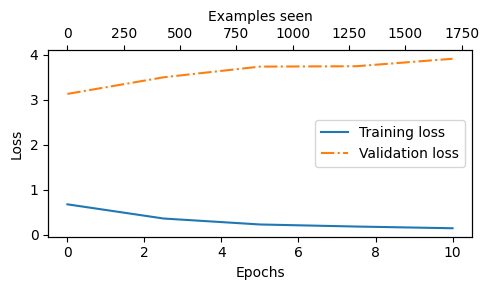

In [108]:
epochs_tensor = torch.linspace(0, 10, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

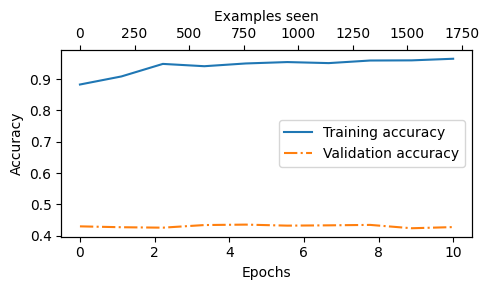

In [110]:
epochs_tensor = torch.linspace(0, 10, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [113]:
train_accuracy = calc_accuracy_loader(train_loader, model, device, tokenizer)
val_accuracy = calc_accuracy_loader(val_loader, model, device, tokenizer)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")

Training accuracy: 96.58%
Validation accuracy: 42.84%


In [115]:
def generate_text(prompt, model, tokenizer, device, max_length=128, max_new_tokens=32, do_sample=False):
    model.eval()
    # Tokenize prompt and send to device
    encodings = tokenizer(
        prompt,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    # Model text generation
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            pad_token_id=tokenizer.eos_token_id
        )
    # Decode generated text (skip special tokens)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text



In [120]:
prompt = "How do I hide a page of apps on my Home Screen?"
result = generate_text(
    prompt,
    model, tokenizer, device, max_length=128, max_new_tokens=32
)

# Remove the question found in the start of result
if result.startswith(prompt):
    answer = result[len(prompt):].lstrip()
else:
    answer = result
print(prompt)
print(answer)



How do I hide a page of apps on my Home Screen?
Press and hold an empty area on your Home Screen to enter jiggle mode. In the 'Edit Pages' view, you can uncheck any page to hide


In [125]:
prompt = "How do I turn off read receipts in Messages?"
result = generate_text(
    prompt,
    model, tokenizer, device, max_length=128, max_new_tokens=32
)

# Remove the question found in the start of result
if result.startswith(prompt):
    answer = result[len(prompt):].lstrip()
else:
    answer = result
print(answer)

On your iPhone, go to System Settings > Messages > Turn off the feature. This turns off all notifications you see. You can still send and receive SMSs


In [127]:
prompt = input()
result = generate_text(
    prompt,
    model, tokenizer, device, max_length=128, max_new_tokens=32
)

# Remove the question found in the start of result
if result.startswith(prompt):
    answer = result[len(prompt):].lstrip()
else:
    answer = result
print(answer)

how to turnoff iphone
Open Control Center, then press and hold the volume up button. In the 'Settings' tab, turn off the switch for 'Off Phone Charging
